In [65]:
# General stuff
import os
import re
import time
import warnings
import math
import sys
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from subprocess import Popen, PIPE
from os.path import join as opj
from IPython.core.debugger import Tracer
from nilearn.decomposition import CanICA,DictLearning
from sklearn.decomposition import DictionaryLearning

# sklearn stuff
from sklearn.decomposition import TruncatedSVD,FastICA,SparsePCA,MiniBatchSparsePCA
from sklearn.utils.extmath import randomized_svd
from sklearn.linear_model import Ridge
from sklearn.decomposition import dict_learning_online
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import scale
import sklearn.metrics.cluster as metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster.hierarchical import _hc_cut # Internal function to cut ward tree, helps speed up things a lot
from sklearn.utils import resample
from sklearn.model_selection import KFold

# personal functions
from importlib import reload
import fsutils as fs
reload(fs)

if os.path.exists('/data1/vbeliveau/'):
    # On NRU server
    cluster_code='/data1/vbeliveau/5HT_clustering'
    cluster_data='/data1/vbeliveau/5HT_clustering_data'
    subjects_dir='/usr/local/nru/freesurfer/subjects'
elif os.path.exists('C:/Users/vbeliveau/'):
    # On laptop
    cluster_code='C:/Users/vbeliveau/Documents/GitHub/5HT_clustering'
    cluster_data='C:/Users/vbeliveau/Documents/5HT_clustering_data'
    subjects_dir='C:/Users/vbeliveau/Downloads/'
else:
    raise ValueError('Unknown location')
    
# Load local version of nilearn
if os.path.exists('/data1/vbeliveau/'):
    sys.path.append('/data1/vbeliveau/nilearn')
    import mynilearn.decomposition as dcm 
    reload(dcm)
elif os.path.exists('C:/Users/vbeliveau/'):
    sys.path.append('C:/Users/vbeliveau/Downloads/nilearn-master')
    import mynilearn.decomposition as dcm
    reload(dcm)
else:
    raise ValueError('Unknown location')
    
# Analysis directories
surf_data=opj(cluster_data,'surf_data')
fs.assert_dir(surf_data)
BPnd_data=opj(cluster_data,'BPnd')
fs.assert_dir(BPnd_data)
MFA_data=opj(cluster_data,'MFA')
MFA_preproc=opj(MFA_data,'preproc')
fs.assert_dir(MFA_data)
fs.assert_dir(MFA_preproc)

info_path=opj(cluster_code,'info_alltracers_base_healthy_hrrt.mat')
hemi_type=['lh','rh']

info=sio.loadmat(info_path)
tracers=['cumi','dasb','sb','az','C36']
petID=[item for subl in info['petID'] for subsubl in subl for item in subsubl]

In [5]:
# Sync data directories
# nrudata.nru.dk/data1 has been mapped to Z:
from dirsync import sync
a=sync('Z:/vbeliveau/5HT_clustering_data',cluster_data,'sync',verbose=True,create=True)

FastICA


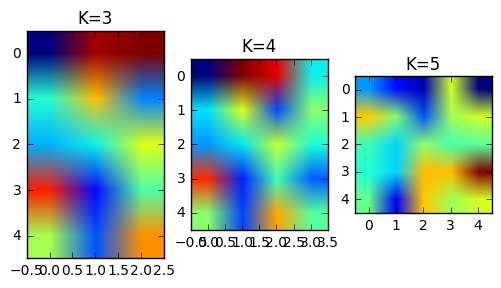

In [32]:
# ICA mean BPnd

tracers=['cumi','dasb','sb','az','C36']
hemi_type=['lh','rh']
targ='fsaverage5'
sm='10'
K_range=np.arange(3,len(tracers)+1)

# Extract data
img=np.ndarray(len(tracers),dtype=object)
data=np.empty(len(tracers),dtype=object)
for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
    for hemi in hemi_type:
        fmask=opj(surf_data,'mask.'+targ+'.'+hemi)
        fname=opj(BPnd_data,'maps',tracer,'mean.mrtm2.nopvc.' + 
                  targ + '.' + hemi + '.sm' + sm + '.nii.gz')
        if data[nt] is None:
            data[nt]=fs.load_surf_data(fname,mask=fmask)
        else:
            data[nt]=np.concatenate((data[nt],fs.load_surf_data(fname,mask=fmask)),axis=0)
data=np.column_stack(data)
            
# Evaluate maps with full dataset
ica=FastICA()
estimators=[ica]
plt.figure()
for estimator in estimators:
    print(estimator.__class__.__name__)
    dest=opj(BPnd_data,estimator.__class__.__name__)
    fs.assert_dir(dest)
    tmp=np.ndarray(len(K_range),dtype=object)
    for nk,ni in zip(K_range,np.arange(0,len(K_range))+1):       
        estimator.set_params(n_components=nk)
        S=estimator.fit_transform(data)
        A=estimator.mixing_
        tmp[ni-1]=S
          
        fout=[opj(dest,'k'+str(nk)+'.'+targ+'.'+hemi+'.sm'+sm+'.nii.gz') for hemi in hemi_type]
        fmask=[opj(surf_data,'mask.'+targ+'.'+hemi) for hemi in hemi_type]
        fs.save_surf_data(S,fout,mask=fmask)
        
        plt.subplot(1,len(K_range),ni)
        plt.title('K='+str(nk))
        plt.imshow(A)
    
    plt.show()

In [3]:
# Load data

tracers=['cumi','dasb','sb','az','C36']
hemi_type=['lh','rh']
targ='fsaverage5'
sm='10'

img=np.ndarray(len(tracers),dtype=object)
data=np.empty(len(tracers),dtype=object)
for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
    for hemi in hemi_type:
        fmask=opj(surf_data,'mask.'+targ+'.'+hemi)
        fname=opj(BPnd_data,'maps',tracer,'mrtm2.nopvc.' + 
                  targ + '.' + hemi + '.sm' + sm + '.nii.gz')
        if data[nt] is None:
            data[nt]=fs.load_surf_data(fname,mask=fmask)
        else:
            data[nt]=np.vstack((data[nt],fs.load_surf_data(fname,mask=fmask)))

In [ ]:
# Run CanICA and DictLearning on concatenated BPnd

warnings.filterwarnings("ignore", message='using a non-integer number instead of an integer')

K_range=np.arange(3,len(tracers)+1)
canica=dcm.CanICA()
dict_learning = dcm.DictLearning()
# estimators=[canica,dict_learning]
estimators=[dict_learning]
for estimator in estimators:
    print(estimator.__class__.__name__)
    dest=opj(BPnd_data,estimator.__class__.__name__)
    fs.assert_dir(dest)
    nib_data=[nib.Nifti1Image(np.reshape(data[nt],[1,data[nt].shape[0],1,data[nt].shape[1]]),
            np.eye(4)) for nt in np.arange(0,len(tracers))]
    mask=nib.Nifti1Image(np.ones([1,data[0].shape[0],1]), np.eye(4))
    estimator.set_params(mask=mask,smoothing_fwhm=None,verbose=False,detrend=False,standardize=False)
    if isinstance(estimator,dcm.CanICA):
        K_range=np.arange(2,10)
        estimator.set_params(threshold=None,max_iter=1000)
    if isinstance(estimator,dcm.DictLearning):
        K_range=[4]
        estimator.set_params(threshold='auto')
    for nk,ni in zip(K_range,np.arange(0,len(K_range))+1):
        estimator.set_params(n_components=nk)
        estimator.fit(nib_data)
        S=estimator.components_.T
        fout=[opj(dest,'k'+str(nk)+'.weights.'+targ+'.'+hemi+'.sm'+sm+'.nii.gz') for hemi in hemi_type]
        fmask=[opj(surf_data,'mask.'+targ+'.'+hemi) for hemi in hemi_type]
        fs.save_surf_data(S,fout,mask=fmask)
        if isinstance(estimator,dcm.DictLearning):
            M=np.argmax(S[:,np.sum(S,axis=0)!=0],axis=1)+1
            fout=[opj(dest,'k'+str(nk)+'.max.'+targ+'.'+hemi+'.sm'+sm+'.nii.gz') for hemi in hemi_type]
            fmask=[opj(surf_data,'mask.'+targ+'.'+hemi) for hemi in hemi_type]
            fs.save_surf_data(M,fout,mask=fmask)

In [7]:
# Create surface maps of MFA weights and plot eigenvalue for a range of smoothness levels

tracers=['cumi','dasb','sb','az','C36']
targ='fsaverage5'
smooth=['0','5','10']
hemi_type=['lh','rh']

Kmax=10 # Maximum number of components to consider
svd=TruncatedSVD(n_components=Kmax,algorithm='arpack')

plot_eigs=False
save_maps=True
dest=opj(MFA_data,'weights')
fs.assert_dir(dest)

for tracer in tracers:
    if plot_eigs:
        plt.figure(figsize=(10,2))
    for sm,nplt in zip(smooth,np.arange(1,len(smooth)+1)):
        # Load the data
        preproc=np.load(opj(MFA_preproc,tracer + '.' + targ + '.sm' + sm + '.npz'))
        data=preproc['arr_0']
        N=len(data)
        
        # Perform SVD
        svd.fit(np.hstack(data).T)
        U=np.transpose(svd.components_)
        S=np.linalg.svd(np.hstack(data),full_matrices=False,compute_uv=False)
        if plot_eigs:
            plt.subplot(1,len(smooth),nplt)
            plt.plot(np.arange(1,Kmax+1),S[0:Kmax])
            plt.title(tracer + ', sm' + sm)
            
        if save_maps: # Save weights out as surface overlay
            fname=[opj(dest,tracer + '.' + targ +'.' +hemi+ '.sm' + sm + '.nii.gz') 
                   for hemi in hemi_type]
            fmask=[opj(surf_data,'mask.'+targ+'.'+hemi) for hemi in hemi_type]
            fs.save_surf_data(U,fname,mask=fmask)
    if plot_eigs:
        plt.show()

Saving surface data to file /data1/vbeliveau/5HT_clustering_data/MFA/weights/cumi.fsaverage5.lh.sm0.nii.gz
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/MFA/weights/cumi.fsaverage5.rh.sm0.nii.gz
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/MFA/weights/cumi.fsaverage5.lh.sm5.nii.gz
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/MFA/weights/cumi.fsaverage5.rh.sm5.nii.gz
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/MFA/weights/cumi.fsaverage5.lh.sm10.nii.gz
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/MFA/weights/cumi.fsaverage5.rh.sm10.nii.gz
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/MFA/weights/dasb.fsaverage5.lh.sm0.nii.gz
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/MFA/weights/dasb.fsaverage5.rh.sm0.nii.gz
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/MFA/weights/dasb.fsaverage5.lh.sm5.nii.gz
Saving surface data to file /data1/

Processing cumi


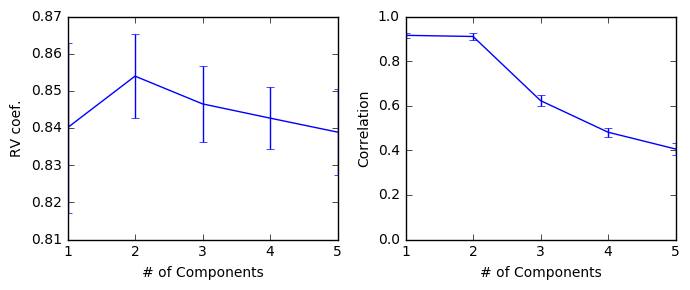

Processing dasb


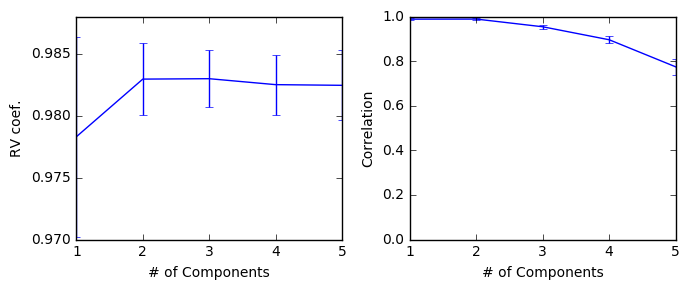

Processing sb


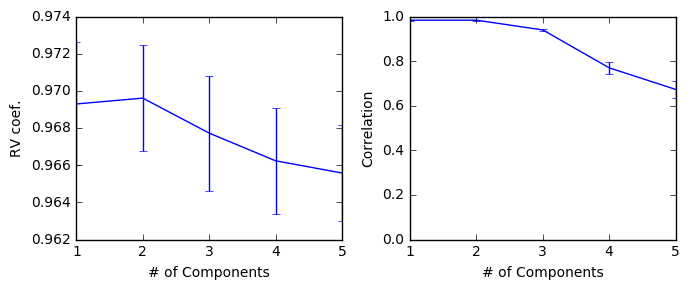

Processing az


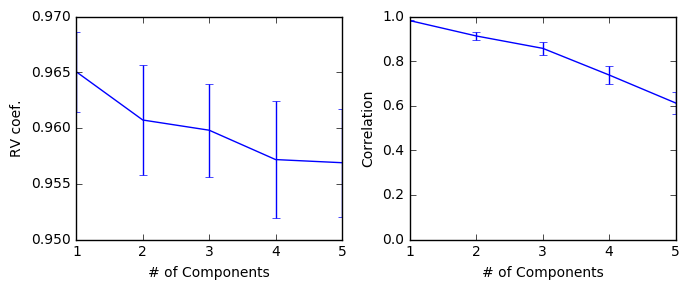

Processing C36


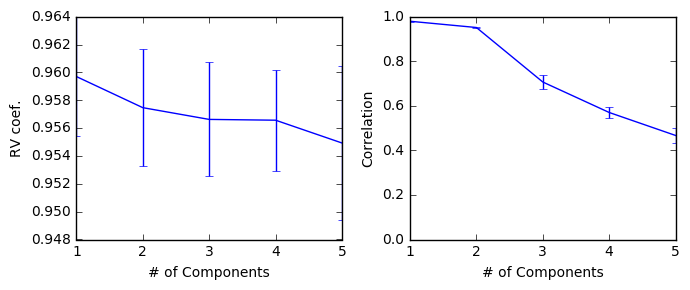

In [70]:
# Evaluate stability and reproducibility of MFA decomposition

tracers=['cumi','dasb','sb','az','C36']
# tracers=['cumi']
targ='fsaverage5'
sm='10'
hemi_type=['lh','rh']
K_range=np.arange(1,6)
N_iter=50

for tracer,nt in zip(tracers,np.arange(0,len(tracers))+1):
    print('Processing '+tracer)
    
    # Load the data
    preproc=np.load(opj(MFA_preproc,tracer + '.' + targ + '.sm' + sm + '.npz'))
    data=preproc['arr_0']
    
    rv=np.ndarray(len(K_range),dtype=object)
    corr=np.ndarray(len(K_range),dtype=object)
    for K,nk in zip(K_range,np.arange(0,len(K_range))):
        def func(data):
            U,S,_=randomized_svd(np.column_stack(data),K)
            return (U.T * S[:, np.newaxis]).T
            
        rv[nk],corr[nk]=fs.split_half(data,func,n_iter=N_iter)
        
    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1)
    plt.errorbar(K_range,
                 [rv_k.mean() for rv_k in rv],
                 yerr=[rv_k.std() for rv_k in rv])
    plt.xticks(K_range)
    plt.xlabel('# of Components')
    plt.ylabel('RV coef.')

    plt.subplot(1,2,2)
    plt.errorbar(K_range,
                 [corr_k.mean(axis=1).mean() for corr_k in corr],
                 yerr=[corr_k.mean(axis=1).std() for corr_k in corr])
    plt.xticks(K_range)
    plt.axis([K_range[0],K_range[-1],0,1])
    plt.xlabel('# of Components')
    plt.ylabel('Correlation')

    plt.tight_layout()
    plt.show()

In [66]:
# Perform MFA+DictLearning on whole dataset

from sklearn.model_selection import StratifiedKFold

tracers=['cumi','dasb','sb','az','C36']
# tracers=['cumi']
targ='fsaverage5'
sm='10'
hemi_type=['lh','rh']
K_opt={'cumi': 2, 'dasb': 3,'sb': 2, 'az': 1,'C36': 2}
K=11

print('Loading data')
data=np.ndarray(0,dtype=object)
groups=[]
for tracer,nt in zip(tracers,np.arange(0,len(tracers))+1):
    preproc=np.load(opj(MFA_preproc,tracer + '.' + targ + '.sm' + sm + '.npz'))
    data=np.append(data,preproc['arr_0'])
    groups=np.append(groups,np.repeat(tracer,len(preproc['arr_0'])))

def func(data,groups):
    K_opt={'cumi': 2, 'dasb': 3,'sb': 2, 'az': 1,'C36': 2}
    group_types=np.unique(groups)
    MFA_components=np.ndarray(len(group_types),dtype=object)
    for group,ng in zip(group_types,np.arange(0,len(group_types))):
        U,S,_=randomized_svd(np.column_stack(data[groups==group]),
                             K_opt[group])
        MFA_components[ng]=(U.T * S[:, np.newaxis]).T
    MFA_components=np.column_stack(MFA_components).T

    ica=FastICA(n_components=K,fun='cube',max_iter=2000)
    ica.fit(MFA_components)
    S = (ica.components_ ** 2).sum(axis=1)
    S[S == 0] = 1
    ica.components_ /= S[:, np.newaxis]

    ridge = Ridge(fit_intercept=None, alpha=1e-8)
    ridge.fit(ica.components_.T, np.asarray(MFA_components.T))
    loadings = ridge.coef_.T
    S = np.sqrt(np.sum(loadings ** 2, axis=0))
    S[S == 0] = 1
    loadings /= S[np.newaxis, :]

    n_features=MFA_components.shape[1]
    batch_size=20
    n_iter = ((n_features - 1) // batch_size + 1)
    components, _ = dict_learning_online(
            MFA_components.T, K, alpha=50, n_iter=n_iter,
            batch_size=20, method='cd',
            dict_init=loadings, return_code=True, shuffle=True)
    components=components.T
    
    S = np.sqrt(np.sum(components ** 2, axis=1))
    S[S == 0] = 1
    components /= S[:, np.newaxis]

    for comp in components:
        if np.sum(comp > 0) < np.sum(comp < 0):
            comp *= -1 

    return components.T

components=func(data,groups)

fout=[opj(MFA_data,'test.'+hemi+'.nii.gz') for hemi in hemi_type]
fmask=[opj(surf_data,'mask.'+targ+'.'+hemi) for hemi in hemi_type]
fs.save_surf_data(components,fout,mask=fmask)

kf=StratifiedKFold(n_splits=2,shuffle=True,random_state=None) # Split-half model
split1,split2=kf.split(np.arange(0,len(groups)),groups)

components1=func(data[split1[0]],groups[split1[0]])
components2=func(data[split2[0]],groups[split2[0]])
 
components1=fs.balance_components(components,components1,metric='cos')
components2=fs.balance_components(components,components2,metric='cos')

fout=[opj(MFA_data,'test1.'+hemi+'.nii.gz') for hemi in hemi_type]
fmask=[opj(surf_data,'mask.'+targ+'.'+hemi) for hemi in hemi_type]
fs.save_surf_data(components1,fout,mask=fmask)

fout=[opj(MFA_data,'test2.'+hemi+'.nii.gz') for hemi in hemi_type]
fmask=[opj(surf_data,'mask.'+targ+'.'+hemi) for hemi in hemi_type]
fs.save_surf_data(components2,fout,mask=fmask)


Loading data


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:296: UserWarning: n_components is too large: it will be set to 10
  warnings.warn('n_components is too large: it will be set to %s' % n_components)
/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


In [39]:
from sklearn.metrics.pairwise import cosine_similarity



array([ -1.05500198e-01,   0.00000000e+00,   1.02516408e-01,
         0.00000000e+00,   0.00000000e+00,  -2.10623148e-01,
         3.30840671e-03,   3.60106526e-03,   0.00000000e+00,
        -1.41146395e-02,  -2.52680301e-05])

In [44]:
fs.balance_components(components,components1)

> /indirect/data1/vbeliveau/5HT_clustering/fsutils.py(33)balance_components()
     31     for nk in np.arange(0,nt):
     32         Tracer()()
---> 33         if metric=='corr':
     34             cc=[np.dot(src[:,nk].T,trg[:,ct]) for ct in trg_ind]
     35         elif metric=='cos':

ipdb> np.std(trg[:,ct])
*** NameError: name 'ct' is not defined
ipdb> n
> /indirect/data1/vbeliveau/5HT_clustering/fsutils.py(34)balance_components()
     32         Tracer()()
     33         if metric=='corr':
---> 34             cc=[np.dot(src[:,nk].T,trg[:,ct]) for ct in trg_ind]
     35         elif metric=='cos':
     36             cc=[np.dot(src[:,nk].T,trg[:,ct]) for ct in trg_ind]

ipdb> n
> /indirect/data1/vbeliveau/5HT_clustering/fsutils.py(37)balance_components()
     35         elif metric=='cos':
     36             cc=[np.dot(src[:,nk].T,trg[:,ct]) for ct in trg_ind]
---> 37         ind=np.argmax(np.abs(cc))
     38         src_ind[nk]=trg_ind[ind]
     39         trg_ind=np.delete(trg_

array([[  8.68440831e-04,   7.64413707e-04,   2.74070191e-06, ...,
          6.92090616e-04,  -8.36193283e-04,  -1.03962809e-03],
       [  8.68440831e-04,   7.64413707e-04,   2.74070191e-06, ...,
          6.92090616e-04,  -1.53016129e-02,  -1.03962809e-03],
       [  8.68440831e-04,   7.64413707e-04,   2.74070191e-06, ...,
          6.92090616e-04,   2.38524573e-02,  -1.03962809e-03],
       ..., 
       [  8.68440831e-04,   7.64413707e-04,   2.74070191e-06, ...,
          6.92090616e-04,  -8.36193283e-04,  -1.03962809e-03],
       [  8.68440831e-04,   7.64413707e-04,   2.74070191e-06, ...,
          6.92090616e-04,  -8.36193283e-04,   3.70125588e-04],
       [  8.68440831e-04,   1.43635189e-02,   2.74070191e-06, ...,
          6.92090616e-04,  -8.36193283e-04,   1.14567579e-02]])

In [46]:
components/np.std(components,axis=0)


array([[ 0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        ,  0.        , -2.62755225, ...,  0.        ,
        -0.        ,  0.        ],
       [ 0.        , -0.        ,  3.90877551, ..., -0.43669574,
         0.        , -0.        ],
       ..., 
       [-0.        ,  1.7109387 , -0.        , ...,  3.06833539,
        -0.        ,  0.42921491],
       [-0.        ,  2.21941992, -0.        , ...,  0.88462673,
        -0.        ,  1.16539767],
       [-0.        ,  1.74430005, -0.        , ...,  0.        ,
        -0.        ,  2.35051346]])

In [59]:
(A/A.std(axis=0)).std(axis=0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

Loading data
Processing K=2
Processing K=3


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Processing K=4
Processing K=5
Processing K=6
Processing K=7
Processing K=8
Processing K=9


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Processing K=10
Processing K=11


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:296: UserWarning: n_components is too large: it will be set to 10
  warnings.warn('n_components is too large: it will be set to %s' % n_components)


Processing K=12
Processing K=13
Processing K=14
Processing K=15
Processing K=16
Processing K=17
Processing K=18
Processing K=19


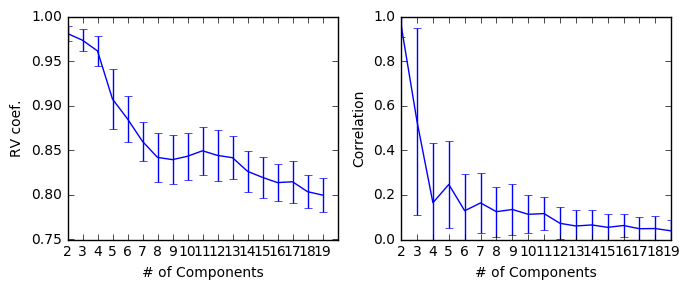

In [20]:
# Evaluate stability and reproducibility of MFA+DictLearning

tracers=['cumi','dasb','sb','az','C36']
# tracers=['cumi']
targ='fsaverage5'
sm='10'
hemi_type=['lh','rh']
K_range=np.arange(2,20)
N_iter=50

print('Loading data')
data=np.ndarray(0,dtype=object)
groups=[]
for tracer,nt in zip(tracers,np.arange(0,len(tracers))+1):
    preproc=np.load(opj(MFA_preproc,tracer + '.' + targ + '.sm' + sm + '.npz'))
    data=np.append(data,preproc['arr_0'])
    groups=np.append(groups,np.repeat(tracer,len(preproc['arr_0'])))

rv=np.ndarray(len(K_range),dtype=object)
corr=np.ndarray(len(K_range),dtype=object)
for K,nk in zip(K_range,np.arange(0,len(K_range))):
    
    print('Processing K='+str(K))
    
    def func(data,args):
        groups=args
        K_opt={'cumi': 2, 'dasb': 3,'sb': 2, 'az': 1,'C36': 2}
        group_types=np.unique(groups)
        MFA_components=np.ndarray(len(group_types),dtype=object)
        for group,ng in zip(group_types,np.arange(0,len(group_types))):
            U,S,_=randomized_svd(np.column_stack(data[groups==group]),
                                 K_opt[group])
            MFA_components[ng]=(U.T * S[:, np.newaxis]).T
        MFA_components=np.column_stack(MFA_components).T

        ica=FastICA(n_components=K,fun='cube',max_iter=2000)
        ica.fit(MFA_components)
        S = (ica.components_ ** 2).sum(axis=1)
        S[S == 0] = 1
        ica.components_ /= S[:, np.newaxis]

        ridge = Ridge(fit_intercept=None, alpha=1e-8)
        ridge.fit(ica.components_.T, np.asarray(MFA_components.T))
        loadings = ridge.coef_.T
        S = np.sqrt(np.sum(loadings ** 2, axis=0))
        S[S == 0] = 1
        loadings /= S[np.newaxis, :]

        n_features=MFA_components.shape[1]
        batch_size=20
        n_iter = ((n_features - 1) // batch_size + 1)
        components, _ = dict_learning_online(
                MFA_components.T, K, alpha=50, n_iter=n_iter,
                batch_size=20, method='cd',
                dict_init=loadings, return_code=True, shuffle=True)
        components=components.T
        # Unit-variance scaling
        S = np.sqrt(np.sum(components ** 2, axis=1))
        S[S == 0] = 1
        components /= S[:, np.newaxis]

        for comp in components:
            if np.sum(comp > 0) < np.sum(comp < 0):
                comp *= -1 
        
        return components.T
    
    rv[nk],corr[nk]=fs.split_half(data,func,n_iter=N_iter,
                                  groups=groups,repro_metric='cos')
    
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.errorbar(K_range,
             [rv_k.mean() for rv_k in rv],
             yerr=[rv_k.std() for rv_k in rv])
plt.xticks(K_range)
plt.xlabel('# of Components')
plt.ylabel('RV coef.')

plt.subplot(1,2,2)
plt.errorbar(K_range,
             [corr_k.mean(axis=1).mean() for corr_k in corr],
             yerr=[corr_k.mean(axis=1).std() for corr_k in corr])
plt.xticks(K_range)
plt.axis([K_range[0],K_range[-1],0,1])
plt.xlabel('# of Components')
plt.ylabel('Correlation')

plt.tight_layout()
plt.show()

In [16]:
# Investigate DictLearning

from sklearn.utils.extmath import randomized_svd
from sklearn.linear_model import Ridge
from sklearn.decomposition import dict_learning_online

warnings.filterwarnings("ignore", message='using a non-integer number instead of an integer')

tracers=['cumi']
targ='fsaverage5'
sm='5'
hemi_type=['lh','rh']
n_components=10
    
dict_learning = dcm.DictLearning()
estimators=[dict_learning]
for tracer in tracers:
    
    print('Processing '+tracer)
    
    # Load the data
    preproc=np.load(opj(MFA_preproc,tracer + '.' + targ + '.sm' + sm + '.npz'))
    data=np.column_stack(preproc['arr_0'])
    nib_data=nib.Nifti1Image(np.reshape(data,[1,data.shape[0],1,data.shape[1]]),np.eye(4))
    mask=nib.Nifti1Image(np.ones([1,data.shape[0],1]), np.eye(4))

    dict_learning.set_params(mask=mask,smoothing_fwhm=None,detrend=False,
                     standardize=False,verbose=False)
    dict_learning.set_params(threshold='auto')
    dict_learning.set_params(n_components=n_components)
    dict_learning.fit(nib_data)

    fout=[opj(MFA_data,'data.'+hemi+'.nii.gz') for hemi in hemi_type]
    fmask=[opj(surf_data,'mask.'+targ+'.'+hemi) for hemi in hemi_type]
    fs.save_surf_data(dict_learning.data.T,fout,mask=fmask)
    
    fout=[opj(MFA_data,'components_init.'+hemi+'.nii.gz') for hemi in hemi_type]
    fmask=[opj(surf_data,'mask.'+targ+'.'+hemi) for hemi in hemi_type]
    fs.save_surf_data(dict_learning.components_init_.T,fout,mask=fmask)
    
    fout=[opj(MFA_data,'components.'+hemi+'.nii.gz') for hemi in hemi_type]
    fmask=[opj(surf_data,'mask.'+targ+'.'+hemi) for hemi in hemi_type]
    fs.save_surf_data(dict_learning.components_.T,fout,mask=fmask)
        
    U,S,_=randomized_svd(data,n_components=2)
    U = U.T * S[:, np.newaxis]

    fout=[opj(MFA_data,'test.data.'+hemi+'.nii.gz') for hemi in hemi_type]
    fmask=[opj(surf_data,'mask.'+targ+'.'+hemi) for hemi in hemi_type]
    fs.save_surf_data(U.T,fout,mask=fmask)
    
    canica = CanICA(n_components=n_components,
                    # CanICA specific parameters
                    do_cca=True, threshold=None,
                    n_init=1)
    canica._raw_fit(U)
    components = canica.components_
    S = (components ** 2).sum(axis=1)
    S[S == 0] = 1
    components /= S[:, np.newaxis]

    fout=[opj(MFA_data,'test.components_init.'+hemi+'.nii.gz') for hemi in hemi_type]
    fmask=[opj(surf_data,'mask.'+targ+'.'+hemi) for hemi in hemi_type]
    fs.save_surf_data(components.T,fout,mask=fmask)
    
    ridge = Ridge(fit_intercept=None, alpha=1e-8)
    ridge.fit(components.T, np.asarray(U.T))
    loadings = ridge.coef_.T
    S = np.sqrt(np.sum(loadings ** 2, axis=0))
    S[S == 0] = 1
    loadings /= S[np.newaxis, :]
    
    components, _ = dict_learning_online(
            U.T, n_components, alpha=10, n_iter=936,
            batch_size=20, method='cd',
            dict_init=loadings, return_code=True, shuffle=True)
    components=components.T
    # Unit-variance scaling
    S = np.sqrt(np.sum(components ** 2, axis=1))
    S[S == 0] = 1
    components /= S[:, np.newaxis]

    for comp in components:
        if np.sum(comp > 0) < np.sum(comp < 0):
            comp *= -1
            
    fout=[opj(MFA_data,'test.components.'+hemi+'.nii.gz') for hemi in hemi_type]
    fmask=[opj(surf_data,'mask.'+targ+'.'+hemi) for hemi in hemi_type]
    fs.save_surf_data(components.T,fout,mask=fmask)
    
    print(fs.RV(components.T,dict_learning.components_.T))

In [5]:
dict_learning.components_.shape

(10, 18715)

In [8]:
# Perform CanICA and DictLearning for each tracer and save maps out

warnings.filterwarnings("ignore", message='using a non-integer number instead of an integer')

tracers=['cumi','dasb','sb','az','C36']
targ='fsaverage5'
sm='5'
hemi_type=['lh','rh']
    
canica=dcm.CanICA()
dict_learning = dcm.DictLearning()
estimators=[canica,dict_learning]
for tracer in tracers:
    
    print('Processing '+tracer)
    
    # Load the data
    preproc=np.load(opj(MFA_preproc,tracer + '.' + targ + '.sm' + sm + '.npz'))
    data=np.column_stack(preproc['arr_0'])
    nib_data=nib.Nifti1Image(np.reshape(data,[1,data.shape[0],1,data.shape[1]]),np.eye(4))
    mask=nib.Nifti1Image(np.ones([1,data.shape[0],1]), np.eye(4))
    
    for estimator in estimators:
        print(estimator.__class__.__name__)
        dest=opj(MFA_data,estimator.__class__.__name__)
        fs.assert_dir(dest)
        estimator.set_params(mask=mask,smoothing_fwhm=None,detrend=False,
                             standardize=False,verbose=False)
        if isinstance(estimator,dcm.CanICA):
            K_range=np.arange(2,10)
            estimator.set_params(threshold=None,max_iter=2000)
        if isinstance(estimator,dcm.DictLearning):
            K_range=np.arange(2,10)
            estimator.set_params(threshold='auto')
        for nk,ni in zip(K_range,np.arange(0,len(K_range))+1):
            estimator.set_params(n_components=nk)
            estimator.fit(nib_data)
            S=estimator.components_.T
            fout=[opj(dest,tracer+'.k'+str(nk)+'.'+targ+'.'+hemi+'.sm'+sm+'.nii.gz') for hemi in hemi_type]
            fmask=[opj(surf_data,'mask.'+targ+'.'+hemi) for hemi in hemi_type]
            fs.save_surf_data(S,fout,mask=fmask)

Processing cumi
CanICA


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the

DictLearning
Processing dasb
CanICA
DictLearning
Processing sb
CanICA
DictLearning
Processing az
CanICA


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


DictLearning
Processing C36
CanICA


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


DictLearning


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [42]:
# Perform CanICA and DictLearning on MFA components for each tracer.

warnings.filterwarnings("ignore", message='using a non-integer number instead of an integer')

tracers=['cumi','dasb','sb','az','C36']
targ='fsaverage5'
sm='10'
hemi_type=['lh','rh']

# Extract MFA components
U=np.ndarray(len(tracers),dtype=object)
svd=TruncatedSVD(algorithm='arpack')
nib_data=np.ndarray(len(tracers),dtype=object)
for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
    
    # Load the data
    preproc=np.load(opj(MFA_preproc,tracer + '.' + targ + '.sm' + sm + '.npz'))
    data=np.column_stack(preproc['arr_0'])
    nib_data[nt]=nib.Nifti1Image(np.reshape(data,[1,data.shape[0],1,data.shape[1]]),np.eye(4))

mask=nib.Nifti1Image(np.ones([nib_data[0].shape[0],nib_data[0].shape[1],
                              nib_data[0].shape[2]]), np.eye(4))

# Perform CanICA and DictLearning
canica=dcm.CanICA()
dict_learning=dcm.DictLearning() # from sklearn, not nilearn
K_range=np.arange(3,10)
estimators=[canica,dict_learning]

for estimator in estimators:
    
    print(estimator.__class__.__name__)
    dest=opj(MFA_data,estimator.__class__.__name__)
    fs.assert_dir(dest)
    
    estimator.set_params(mask=mask,smoothing_fwhm=None,verbose=False,
                         detrend=False,standardize=False)
    if isinstance(estimator,dcm.CanICA):
        K_range=np.arange(2,15)
        estimator.set_params(threshold=None,max_iter=2000)
    if isinstance(estimator,dcm.DictLearning):
        K_range=np.arange(2,15)
        estimator.set_params(threshold='auto')
    
    for nk,ni in zip(K_range,np.arange(0,len(K_range))+1):
        
        print('K='+str(nk))  
        estimator.set_params(n_components=nk)
        estimator.fit(nib_data)

        fout=[opj(dest,'all.k'+str(nk)+'.'+targ+'.'+hemi+'.sm'+sm+'.nii.gz') for hemi in hemi_type]
        fmask=[opj(surf_data,'mask.'+targ+'.'+hemi) for hemi in hemi_type]
        fs.save_surf_data(estimator.components_.T,fout,mask=fmask)


CanICA
K=2
K=3
K=4


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


K=5


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


K=6


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


K=7


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


K=8


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


K=9


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


K=10


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


K=11


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


K=12


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


K=13
K=14


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


DictLearning
K=2
K=3
K=4
K=5
K=6
K=7
K=8
K=9
K=10
K=11
K=12
K=13
K=14


In [ ]:
# Try performing decomposition using DictionaryLearning from sklearn directly rather than
# using DictLearning from nilearn

warnings.filterwarnings("ignore", message='using a non-integer number instead of an integer')

tracers=['cumi','dasb','sb','az','C36']
targ='fsaverage5'
sm='10'
hemi_type=['lh','rh']

# Extract MFA components
U=np.ndarray(len(tracers),dtype=object)
svd=TruncatedSVD(algorithm='arpack')
nib_data=np.ndarray(len(tracers),dtype=object)
for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
    
    # Load the data
    preproc=np.load(opj(MFA_preproc,tracer + '.' + targ + '.sm' + sm + '.npz'))
    data=preproc['arr_0']
    data=np.column_stack(data)
    nib_data[nt]=nib.Nifti1Image(np.reshape(data,[1,data.shape[0],1,data.shape[1]]),np.eye(4))

mask=nib.Nifti1Image(np.ones([nib_data[0].shape[0],nib_data[0].shape[1],
                              nib_data[0].shape[2]]), np.eye(4))

# Perform CanICA and DictLearning
canica=dcm.CanICA()
dict_learning=dcm.DictLearning() # from sklearn, not nilearn
K_range=np.arange(3,10)
estimators=[canica,dict_learning]

for estimator in estimators:
    
    print(estimator.__class__.__name__)
    dest=opj(MFA_data,estimator.__class__.__name__)
    fs.assert_dir(dest)
    
    estimator.set_params(mask=mask,smoothing_fwhm=None,verbose=False,
                         detrend=False,standardize=False)
    if isinstance(estimator,dcm.CanICA):
        K_range=np.arange(2,15)
        estimator.set_params(threshold=None,max_iter=2000)
    if isinstance(estimator,dcm.DictLearning):
        K_range=np.arange(2,15)
        estimator.set_params(threshold='auto')
    
    for nk,ni in zip(K_range,np.arange(0,len(K_range))+1):
        
        print('K='+str(nk))  
        estimator.set_params(n_components=nk)
        estimator.fit(nib_data)

        fout=[opj(dest,'all.k'+str(nk)+'.'+targ+'.'+hemi+'.sm'+sm+'.nii.gz') for hemi in hemi_type]
        fmask=[opj(surf_data,'mask.'+targ+'.'+hemi) for hemi in hemi_type]
        fs.save_surf_data(estimator.components_.T,fout,mask=fmask)

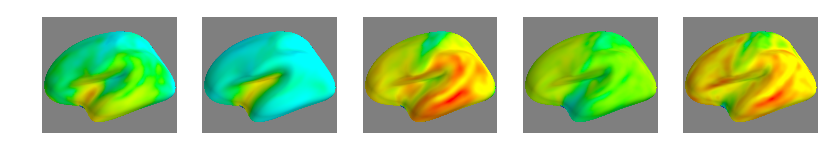

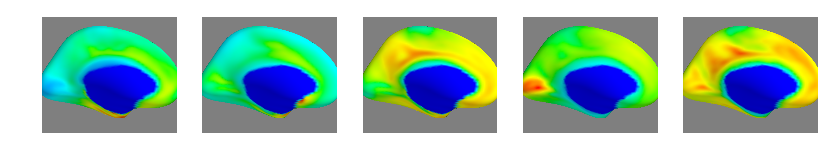

In [27]:
# Plot BPnd and MFA maps side by side
%gui qt

tracers=['cumi','dasb','sb','az','C36']
targ='fsaverage5'
sm='10'
hemi='lh'
fsurf=opj(subjects_dir,targ,'surf',hemi+'.inflated')

img=np.ndarray(len(tracers),dtype=object)
for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
    fname=opj(BPnd_data,'maps',tracer,'mean.mrtm2.nopvc.'+targ+'.'+hemi+'.sm'+sm+'.nii.gz')
    data=fs.load_surf_data(fname)
    img[nt]=fs.surf_view(fsurf,data=data,view=['mid','side'],hemi=hemi,snap=True)

for ni in np.arange(0,len(img[0])):
    plt.figure(figsize=(10,2))
    for nt in np.arange(0,len(tracers)):
        plt.subplot(1,len(img),nt+1)
        plt.axis('off')
        plt.imshow(img[nt][ni])
    plt.show()

In [ ]:
# Perform bootstrap of the MFA components to obtain an estimate of each component at the vertice level
# The goal here is to identify components containing significant "structures", and keep those components

tracers=['cumi','dasb','sb','az','C36']
# tracers=['cumi']
targ='fsaverage5'
sm='5'

Niter=500 # Number of iterations (usually ~1000 or 10000)
Nupdate=50 # Number of iteration for verbose update
Kmax=10 # Maximum number of components to consider

conf=0.025

for tracer in tracers:
    
    # Load the data
    preproc=np.load(opj(MFA_data,tracer,'preproc.' + targ + '.sm' + sm + '.npz'))
    data=preproc['arr_0']
    eig1=preproc['arr_1']
    N=data.shape[0]
    Nvert=data[0].shape[0]
    
    # Divide all datasets by first eigenval
    for ns in np.arange(0,N):
        data[ns]=data[ns]/eig1[ns] # Consider multiplying by a large number before division to avoid numerical instabilities
        
    svd=TruncatedSVD(n_components=Kmax,algorithm='arpack')
    svd.fit(np.hstack(data).T)
    U=np.transpose(svd.components_)
    S=np.linalg.svd(np.hstack(data), full_matrices=False, compute_uv=False)
    
    Zboot=np.ndarray([Nvert,Niter,Kmax])
    Sboot=np.ndarray([Kmax,Niter])
    start_t = time.time()
    if (Nupdate>0):
        print('Processing ' + tracer)
    for ni in np.arange(0,Niter): # Will need to parallelize this

        if (Nupdate>0 and ni % Nupdate == 0):
            print('Iter ' + str(ni))    
        
        # Get indices for current fold
        ind=resample(np.arange(0,N),replace=True)
        
        # Perform SVD and compute
        svd.fit(np.transpose(np.hstack(data[ind])))
        src_ind,_,Uboot=balance_svd_components(U,np.transpose(svd.components_),return_balanced=True)
        Zboot[:,ni,:]=scale(Uboot)
        Sboot[:,ni]=np.linalg.svd(np.hstack(data[ind]), full_matrices=False, compute_uv=False)[src_ind]
            
    # Build 95% confidence interval and find if 0 is within the interval at each vertice
    sig=np.empty([Nvert,Kmax])
    for nk in np.arange(0,Kmax):
        Zboot[:,:,nk]=np.sort(Zboot[:,:,nk],axis=1)
        ind=Zboot[:,Niter-1,nk]>0
        nind=np.logical_not(ind)
        sig[ind,nk]=Zboot[ind,int(np.round(Zboot.shape[1]*conf)),nk]>0 # 0 is not in the lower tail
        sig[nind,nk]=Zboot[nind,int(np.round(Zboot.shape[1]*conf)),nk]<0 # 0 is not in the upper tail
                    
    # Save components and eigval
    np.savez(opj(MFA_data,tracer,'bootstrap.data.' +  targ +'.sm' + sm),Zboot,Sboot,sig)
    
    # Save out mean Z maps and significant vertices as surface overlays
    fmask=[opj(surf_data,targ,hemi) for hemi in hemi_type]
    fname=opj(MFA_data,tracer,'bootstrap.Zmean.' + hemi + '.' + targ + '.sm' + sm + '.nii.gz')
    fs.save_surf_data( Zboot.mean(axis=1),fname,mask=fmask,verbose=True)
    fname=opj(MFA_data,tracer,'bootstrap.sig.' + hemi + '.' + targ + '.sm' + sm + '.nii.gz')
    fs.save_surf_data(sig,fname,mask=fmask,verbose=True)

Processing cumi


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


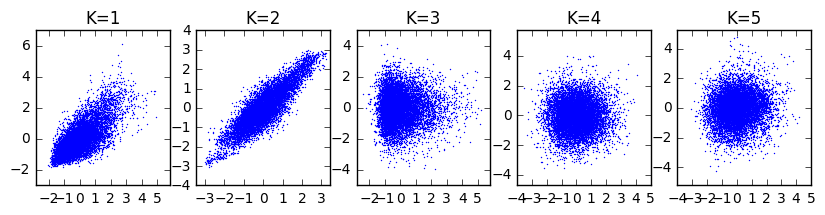

Processing dasb


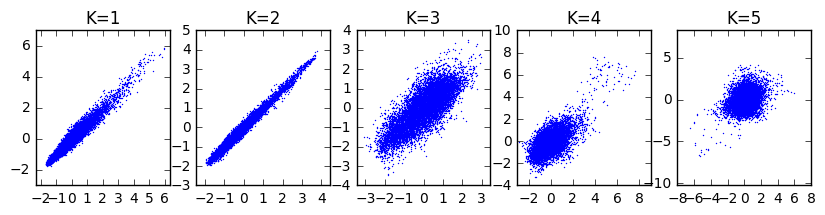

Processing sb


Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc (zmq/backend/cython/message.c:4018)
KeyboardInterrupt


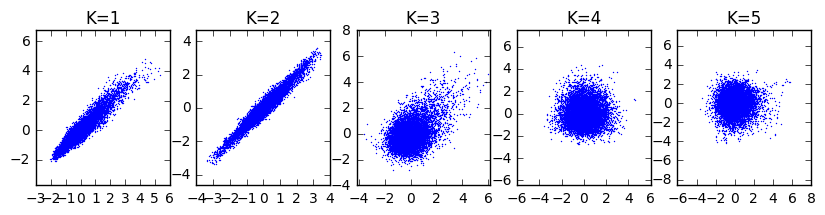

Processing az


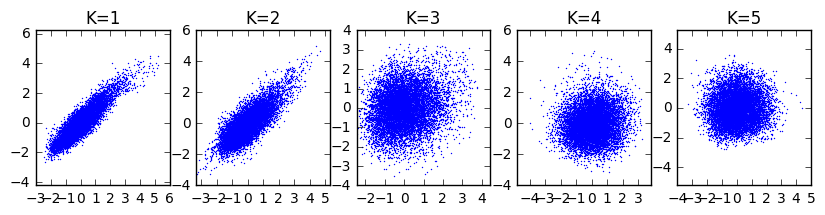

Processing C36


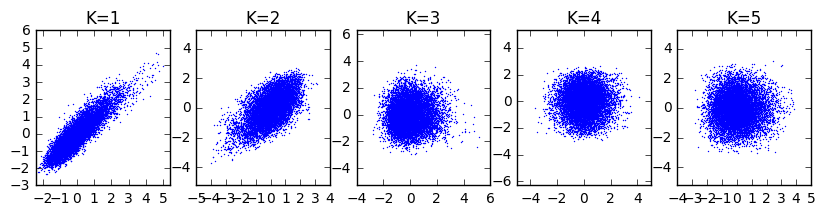

In [24]:
# Perform split-half evaluation the reproducibility of the MFA components

tracers=['cumi','dasb','sb','az','C36']
# tracers=['dasb']
targ='fsaverage5'
sm='5'

Niter=1 # Number of split-half iterations (usually ~1000 or 10000)
Kmax=5 # Maximum number of components to consider

plot_example=True
Nupdate=100

kf=KFold(n_splits=2,shuffle=True) # Split-half model
cc={}
cc_null={}
for tracer in tracers:
    
    # Load the data
    preproc=np.load(opj(MFA_preproc,tracer + '.' + targ + '.sm' + sm + '.npz'))
    data=preproc['arr_0']
    eig1=preproc['arr_1']
    N=data.shape[0]
    
    # Divide all datasets by first eigenval
    for ns in np.arange(0,N):
        data[ns]=data[ns]/eig1[ns] # Consider multiplying by a large number before division to avoid numerical instabilities
        
    svd=TruncatedSVD(n_components=Kmax,algorithm='arpack')    
    start_t = time.time()
    print('Processing ' + tracer)
    for ni in np.arange(0,Niter): # Will need to parallelize this

#         if (Nupdate>0 and ni % 100 == 0):
#             print('Iter ' + str(ni)            
        
        # Get indices for current fold
        split1,split2=kf.split(np.arange(0,N))
        
        # Perform SVD on split 1 & 2, separately
        svd.fit(np.hstack(data[split1[0]]).T)
        U1=scale(svd.components_.T)
        svd.fit(np.hstack(data[split2[0]]).T)
        U2=scale(svd.components_.T)
        [_,_,U2]=fs.balance_svd_components(U1,U2,return_balanced=True)
        
        plt.figure(figsize=(10,2))
        if plot_example:
            for nk in np.arange(0,Kmax):
                plt.subplot(1,Kmax,nk+1)
                plt.scatter(U1[:,nk],U2[:,nk],s=1,lw=0)
                plt.axis('equal')
                plt.title('K=' + str(nk+1))

            plt.show()

/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Performing ward clustering of the whole dataset
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/BPnd/ward/cumi.fsaverage5.lh.nii.gz
Performing split-half evaluation of clustering


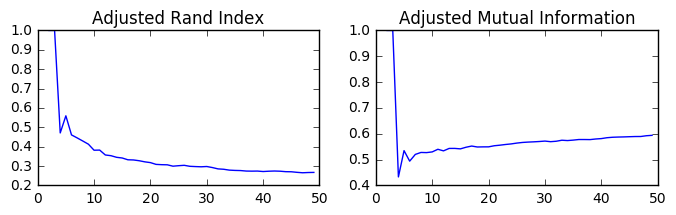

Performing ward clustering of the whole dataset
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/BPnd/ward/dasb.fsaverage5.lh.nii.gz
Performing split-half evaluation of clustering


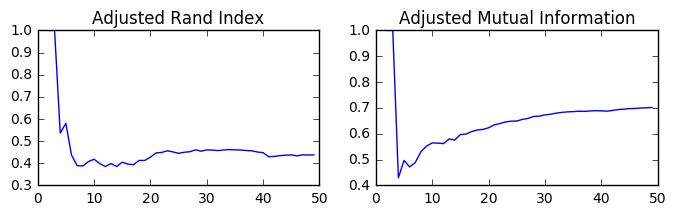

Performing ward clustering of the whole dataset
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/BPnd/ward/sb.fsaverage5.lh.nii.gz
Performing split-half evaluation of clustering


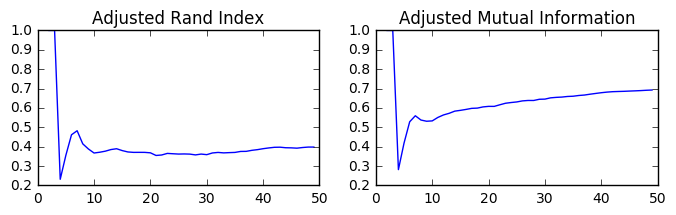

Performing ward clustering of the whole dataset
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/BPnd/ward/az.fsaverage5.lh.nii.gz
Performing split-half evaluation of clustering


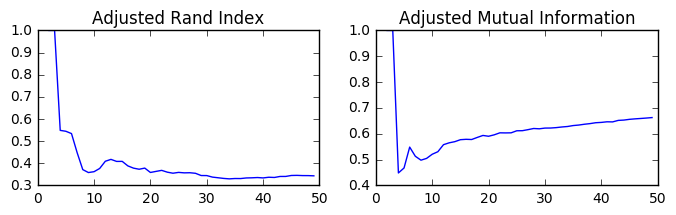

Performing ward clustering of the whole dataset
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/BPnd/ward/C36.fsaverage5.lh.nii.gz
Performing split-half evaluation of clustering


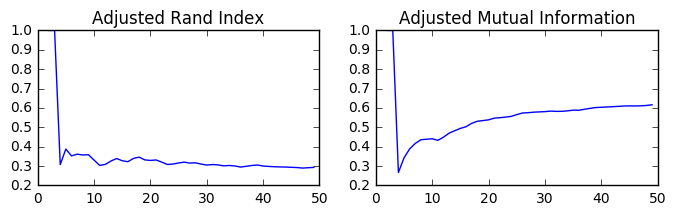

In [10]:
# Cluster BPnd maps using Ward's with spatial constraint
# Dimensionality is estimated based on stability metrics in split-half setting
# This will be useful to see if we gain anything knowledge from decomposing the dynamic data

tracers=['cumi','dasb','sb','az','C36']
# tracers=['cumi']
# hemi_type=['lh','rh']
hemi_type=['lh']
targ='fsaverage5'
sm='10'
    
do_whole=True
do_split=True

K_range=np.arange(2,50,1)
N_iter=10

# Perform Ward clustering on BPnd data
for tracer in tracers:                                            
    for hemi in hemi_type:
        fname=opj(BPnd_data,'maps',tracer,'mrtm2.nopvc.' + targ + '.' + hemi + '.sm' + sm + '.nii.gz')
        fmask=opj(surf_data,'mask.'+targ+'.'+hemi)
        data=fs.load_surf_data(fname,mask=fmask)
        data_scaled=scale(data,axis=0)
        
    dest=opj(BPnd_data,'ward')
    fs.assert_dir(dest)
    nstart=0
    nstop=0
    for hemi in hemi_type:
        adjacency,_=fs.load_surf_neighborhood(opj(surf_data,'neigh.'+targ+'.'+hemi+'.matrix'))
        nstop=nstop+adjacency.shape[0]
        hemi_data=data[nstart:nstop,:]
        if do_whole:        
            fname=opj(dest,tracer + '.'+targ+'.'+hemi+'.nii.gz')
            fmask=opj(surf_data,'mask.'+targ+'.'+hemi)
            fs.ward_clustering(hemi_data,adjacency,mode='whole',K_range=K_range,save_out=fname,
                            mask=fmask,verbose=True)
        if do_split:
            fs.ward_clustering(hemi_data,adjacency,mode='split',K_range=K_range,
                               N_iter=N_iter,verbose=True)    

Performing ward clustering of the whole dataset
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/MFA/ward/cumi.fsaverage5.lh.nii.gz
Performing split-half evaluation of clustering


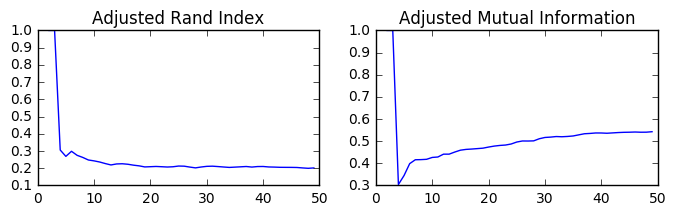

Performing ward clustering of the whole dataset
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/MFA/ward/dasb.fsaverage5.lh.nii.gz
Performing split-half evaluation of clustering


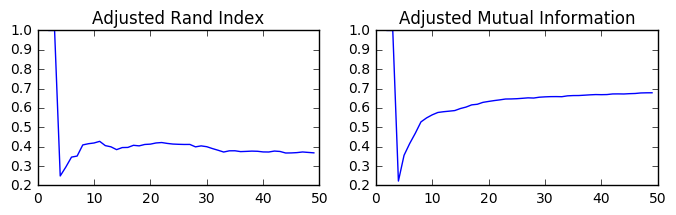

Performing ward clustering of the whole dataset
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/MFA/ward/sb.fsaverage5.lh.nii.gz
Performing split-half evaluation of clustering


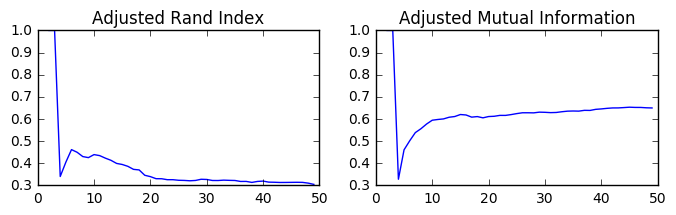

Performing ward clustering of the whole dataset
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/MFA/ward/az.fsaverage5.lh.nii.gz
Performing split-half evaluation of clustering


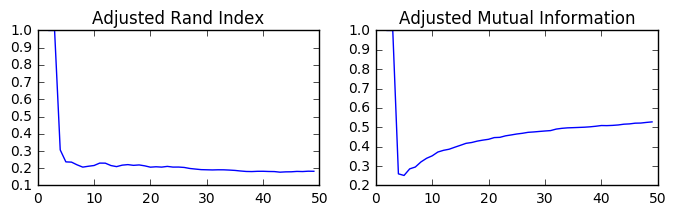

Performing ward clustering of the whole dataset
Saving surface data to file /data1/vbeliveau/5HT_clustering_data/MFA/ward/C36.fsaverage5.lh.nii.gz
Performing split-half evaluation of clustering


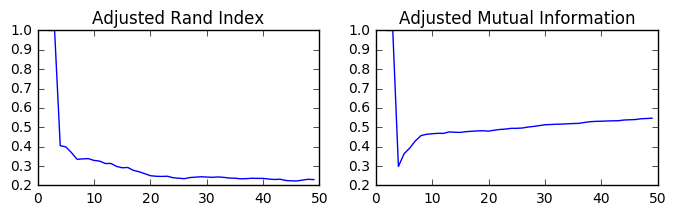

In [4]:
# Cluster MFA components using Ward's with spatial constraint
# Dimensionality is estimated based on stability metrics in split-half setting

tracers=['cumi','dasb','sb','az','C36']
# tracers=['cumi']
# hemi_type=['lh','rh']
hemi_type=['lh']
targ='fsaverage5'
sm='10'

K_opt={'cumi': 2, 'dasb': 3,'sb': 2, 'az': 2,'C36': 1}

do_whole=True
do_split=True

K_range=np.arange(2,50,1)
N_iter=10

# Perform Ward clustering on MFA components
for tracer in tracers:
    
    # Load the data
    preproc=np.load(opj(MFA_preproc,tracer + '.' + targ + '.sm' + sm + '.npz'))
    data=preproc['arr_0']
    eig1=preproc['arr_1']
    
    # Divide all datasets by first eigenval
    for ns in np.arange(0,len(data)):
        data[ns]=data[ns]/eig1[ns] # Consider multiplying by a large number before division to avoid numerical instabilities

    dest=opj(MFA_data,'ward')
    fs.assert_dir(dest)
    nstart=0
    nstop=0
    for hemi in hemi_type:
        adjacency,_=fs.load_surf_neighborhood(opj(surf_data,'neigh.'+targ+'.'+hemi+'.matrix'))
        nstop=nstop+adjacency.shape[0]
        hemi_data=np.ndarray(len(data),dtype='object')
        for ns in np.arange(0,len(data)):
            hemi_data[ns]=data[ns][nstart:nstop,:]
        if do_whole:        
            fname=opj(dest,tracer + '.'+targ+'.'+hemi+'.nii.gz')
            fmask=opj(surf_data,'mask.'+targ+'.'+hemi)
            fs.ward_clustering(hemi_data,adjacency,mode='whole',K_range=K_range,save_out=fname,
                            mask=fmask,svd=True,K_svd=K_opt[tracer],verbose=True)
        if do_split:
            fs.ward_clustering(hemi_data,adjacency,mode='split',K_range=K_range,N_iter=N_iter,
                               svd=True,K_svd=K_opt[tracer],verbose=True)    

In [41]:
# Compute gradient map of MFA weights and BPnd

# modalities={'MFA','BPnd'}
modalities={'MFA'}
targ='fsaverage5'
sm='10'
tracers=['cumi']
hemi_type=['lh']

for hemi in hemi_type:
    for tracer in tracers:
        for modality in modalities:
            
            if modality in 'MFA':
                img=nib.load(opj(MFA_data,'weights',tracer + '.' + hemi + '.' + targ + '.sm' + sm + '.nii.gz'))
                dest=opj(MFA_data,'gradient')
                fs.assert_dir(dest)
            if modality in 'BPnd':
                img=nib.load(opj(BPnd_data,'maps',tracer + '/mean.mrtm2.nopvc.' + 
                             targ + '.' + hemi + '.sm' + sm + '.nii.gz'))
                dest=opj(cluster_data,'BPnd','gradient')
                fs.assert_dir(dest)

            data=img.get_data()
            grad=np.ndarray(data.shape,dtype=data.dtype)
            for nk in np.arange(0,data.shape[3]):
                grad[:,nk]=fs.vlen(fs.build_surface_gradient_matrix(data[0,:,0,nk],opj(targ,hemi +'.pial')),axis=1)

            nib.save(nib.Nifti1Image(grad, np.eye(4)), opj(dest,tracer + hemi + '.' + targ + '.sm' + sm + '.nii.gz'))


ValueError: could not broadcast input array from shape (10242) into shape (1,1,10)

In [22]:
# Compute gradient structure for surfaces

targ_list=['fsaverage5']
hemi=['lh','rh']

for targ in targ_list:
    for hemi in hemi_type:
        fname=opj(subjects_dir,targ,'surf',hemi+'.pial')
        fmask=opj(surf_data,'mask.'+targ+'.'+hemi)
        fout=opj(surf_data,'gradstruct.'+targ+'.'+hemi)
        proj,neigh,cortex,border=fs.surf_gradient_struct(fname,fmask,
                            verbose=True,validate_rotation=True,save_out=fout)

Processing C:/Users/vbeliveau/Downloads/fsaverage5\surf\lh.pial
Extracting cortical vertices bordering medial wall
Computing gradient structure for cortical vertices
Saving gradient structure to C:/Users/vbeliveau/Downloads/5HT_clustering_data\surf_data\gradstruct.fsaverage5.lh
Processing C:/Users/vbeliveau/Downloads/fsaverage5\surf\rh.pial
Extracting cortical vertices bordering medial wall
Computing gradient structure for cortical vertices
Saving gradient structure to C:/Users/vbeliveau/Downloads/5HT_clustering_data\surf_data\gradstruct.fsaverage5.rh


In [34]:
# Compute gradient for BPnd and MFA data

process_BPnd=False
process_MFA=True
tracers=['cumi','dasb','sb','az','C36']
targ='fsaverage5'
hemi_type=['lh','rh']
sm='10'
fgrad=opj(surf_data,'gradstruct.'+targ+'.'+hemi)

# Process BPnd
if process_BPnd:
    grad_dest=opj(BPnd_data,'gradient')
    fs.assert_dir(grad_dest)
    for tracer in tracers:
        tracer_dest=opj(grad_dest,tracer)
        fs.assert_dir(tracer_dest)    
        for hemi in hemi_type:
            fi='mean.mrtm2.nopvc.' + targ + '.' + hemi + '.sm' + sm + '.nii.gz'
            fname=opj(BPnd_data,'maps',tracer,fi)        
            data=fs.load_surf_data(fname)
            save_out=opj(tracer_dest,'grad.'+fi)
            grad=fs.surf_gradient(data,fgrad,save_out=save_out,verbose=True)

# Process MFA
if process_MFA:
    grad_dest=opj(MFA_data,'gradient')
    fs.assert_dir(grad_dest)
    for tracer in tracers:
        tracer_dest=opj(grad_dest,tracer)
        fs.assert_dir(tracer_dest)    
        for hemi in hemi_type:
            fi='mean.mrtm2.nopvc.' + targ + '.' + hemi + '.sm' + sm + '.nii.gz'
            fname=opj(BPnd_data,'maps',tracer,fi)        
            data=fs.load_surf_data(fname)
            save_out=opj(tracer_dest,'grad.'+fi)
            grad=fs.surf_gradient(data,fgrad,save_out=save_out,verbose=True)

Computing gradient
Processing cortical vertices
Processing border vertices
Input dimensions=(10242,), Output dimensions=(1, 10242, 1, 1)
Saving data with dimensions (10242,) to file C:/Users/vbeliveau/Downloads/5HT_clustering_data\BPnd\gradient\cumi\grad.mean.mrtm2.nopvc.fsaverage5.lh.sm10.nii.gz
Computing gradient
Processing cortical vertices
Processing border vertices
Input dimensions=(10242,), Output dimensions=(1, 10242, 1, 1)
Saving data with dimensions (10242,) to file C:/Users/vbeliveau/Downloads/5HT_clustering_data\BPnd\gradient\cumi\grad.mean.mrtm2.nopvc.fsaverage5.rh.sm10.nii.gz
Computing gradient
Processing cortical vertices
Processing border vertices
Input dimensions=(10242,), Output dimensions=(1, 10242, 1, 1)
Saving data with dimensions (10242,) to file C:/Users/vbeliveau/Downloads/5HT_clustering_data\BPnd\gradient\dasb\grad.mean.mrtm2.nopvc.fsaverage5.lh.sm10.nii.gz
Computing gradient
Processing cortical vertices
Processing border vertices
Input dimensions=(10242,), Outp